# Finding the Perfect Spot: WiFi Analytics for Premium Space Advertising


**Author:** Noopur Shekhar Divekar

A graph-inspired approach to identifying high-value advertising locations using anonymous WiFi foot traffic data.

**Analysis pipeline:**
1. Model venue as a connected zone graph
2. Simulate realistic WiFi ping data
3. Reconstruct sessions from irregular pings
4. Compute reach, dwell, throughflow, and repeat metrics
5. Score and rank zones with a weighted Premium Space Score (PSS)
6. Visualize spatial placement candidates

## 1. Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
print('Libraries loaded.')

Libraries loaded.


## 2. Generate Mock Venue Graph & Simulate WiFi Pings

The venue is modeled as a graph where **nodes = zones** and **edges = walkable connections**.
WiFi pings are simulated for 1,500 devices with realistic stickiness, irregular intervals, and session repeat behavior.

In [2]:
def generate_mock_venue(seed=7):
    rng = np.random.default_rng(seed)

    zones = pd.DataFrame([
        {'zone_id': 'ENT_N',  'name': 'North Entrance',    'type': 'entrance', 'x': 10, 'y': 90},
        {'zone_id': 'ENT_S',  'name': 'South Entrance',    'type': 'entrance', 'x': 10, 'y': 10},
        {'zone_id': 'COR_1',  'name': 'Main Corridor 1',   'type': 'corridor', 'x': 30, 'y': 70},
        {'zone_id': 'COR_2',  'name': 'Main Corridor 2',   'type': 'corridor', 'x': 50, 'y': 50},
        {'zone_id': 'COR_3',  'name': 'Main Corridor 3',   'type': 'corridor', 'x': 70, 'y': 30},
        {'zone_id': 'FOOD',   'name': 'Food Court',        'type': 'food',     'x': 80, 'y': 80},
        {'zone_id': 'ANCH_A', 'name': 'Anchor Store A',    'type': 'anchor',   'x': 90, 'y': 60},
        {'zone_id': 'ANCH_B', 'name': 'Anchor Store B',    'type': 'anchor',   'x': 90, 'y': 20},
        {'zone_id': 'GALL_1', 'name': 'Gallery 1',         'type': 'gallery',  'x': 40, 'y': 85},
        {'zone_id': 'GALL_2', 'name': 'Gallery 2',         'type': 'gallery',  'x': 60, 'y': 85},
        {'zone_id': 'REST',   'name': 'Restrooms',         'type': 'utility',  'x': 65, 'y': 10},
        {'zone_id': 'SEAT',   'name': 'Seating / Atrium',  'type': 'amenity',  'x': 55, 'y': 55},
    ])

    edges_list = [
        ('ENT_N','COR_1'), ('ENT_S','COR_3'),
        ('COR_1','COR_2'), ('COR_2','COR_3'),
        ('COR_2','SEAT'),
        ('COR_1','GALL_1'), ('GALL_1','GALL_2'), ('GALL_2','FOOD'),
        ('COR_2','ANCH_A'), ('COR_3','ANCH_B'),
        ('COR_3','REST'),
        ('FOOD','ANCH_A'),
    ]

    adj = {}
    for a, b in edges_list:
        adj.setdefault(a, []).append(b)
        adj.setdefault(b, []).append(a)

    n_devices = 1500
    sessions_per_device = rng.choice([1, 2, 3], size=n_devices, p=[0.72, 0.22, 0.06])
    start = pd.Timestamp('2025-12-01 09:00:00')
    end   = pd.Timestamp('2025-12-01 21:00:00')
    total_minutes = int((end - start).total_seconds() // 60)

    stickiness = {
        'FOOD': 0.65, 'SEAT': 0.55, 'GALL_1': 0.45, 'GALL_2': 0.45,
        'ANCH_A': 0.35, 'ANCH_B': 0.35, 'REST': 0.25,
        'COR_1': 0.15, 'COR_2': 0.15, 'COR_3': 0.15,
        'ENT_N': 0.10, 'ENT_S': 0.10
    }

    def simulate_session(device_id):
        t0 = start + pd.Timedelta(minutes=int(rng.integers(0, total_minutes)))
        duration = int(np.clip(int(rng.normal(75, 25)), 20, 180))
        t1 = t0 + pd.Timedelta(minutes=duration)
        zone = rng.choice(['ENT_N','ENT_S'], p=[0.4, 0.6])
        times = pd.date_range(t0, t1, freq='1min')
        zones_path = []
        for _ in times:
            zones_path.append(zone)
            if rng.random() < stickiness.get(zone, 0.2):
                continue
            nbrs = adj.get(zone, [])
            if not nbrs:
                continue
            weights = np.array([1.35 if n in ['FOOD','ANCH_A','ANCH_B'] else (1.15 if n in ['GALL_1','GALL_2'] else 1.0) for n in nbrs])
            weights /= weights.sum()
            zone = rng.choice(nbrs, p=weights)
        df = pd.DataFrame({'device_id': device_id, 'timestamp': times, 'zone_id': zones_path})
        zmap = zones.set_index('zone_id')[['x','y']].to_dict('index')
        df['x'] = df['zone_id'].map(lambda z: zmap[z]['x'] + rng.normal(0, 2.5))
        df['y'] = df['zone_id'].map(lambda z: zmap[z]['y'] + rng.normal(0, 2.5))
        df['rssi'] = -35 - (np.abs(rng.normal(0, 7, size=len(df))) + rng.uniform(0, 10, size=len(df)))
        return df

    all_sessions = []
    for i in range(n_devices):
        for _ in range(sessions_per_device[i]):
            all_sessions.append(simulate_session(f'd_{i:05d}'))
    traces = pd.concat(all_sessions, ignore_index=True)

    keep = np.zeros(len(traces), dtype=bool)
    for _, g in traces.groupby('device_id', sort=False):
        step = int(rng.integers(2, 6))
        keep[g.iloc[::step].index] = True
    pings = traces.loc[keep].reset_index(drop=True)

    candidates = zones[zones['type'].isin(['corridor','food','amenity','gallery'])].copy()
    candidates['is_candidate'] = True

    return zones, pd.DataFrame(edges_list, columns=['from_zone','to_zone']), pings, candidates

zones, edges, pings, candidates = generate_mock_venue(seed=7)
print(f'Zones: {zones.shape[0]} | Edges: {edges.shape[0]} | Pings: {pings.shape[0]:,}')
pings.head()

Zones: 12 | Edges: 12 | Pings: 49,560


,device_id,timestamp,zone_id,x,y,rssi
0,d_00000,2025-12-01 15:23:00,ENT_N,12.940672,93.517539,-44.317115
1,d_00000,2025-12-01 15:27:00,GALL_2,63.199086,84.494754,-39.361447
2,d_00000,2025-12-01 15:31:00,FOOD,78.271882,83.972922,-39.721543
3,d_00000,2025-12-01 15:35:00,GALL_2,61.157583,86.718931,-41.744486
4,d_00000,2025-12-01 15:39:00,GALL_2,61.858907,82.258041,-46.138516


## 3. Session Reconstruction

WiFi pings are irregular and sparse. Sessions are inferred using a **15-minute inactivity gap** threshold.

In [3]:
def build_sessions(pings, inactivity_gap_minutes=15):
    df = pings.sort_values(['device_id','timestamp']).copy()
    df['prev_ts'] = df.groupby('device_id')['timestamp'].shift(1)
    df['gap_min'] = (df['timestamp'] - df['prev_ts']).dt.total_seconds() / 60.0
    df['new_sess'] = df['prev_ts'].isna() | (df['gap_min'] > inactivity_gap_minutes)
    df['session_id'] = df.groupby('device_id')['new_sess'].cumsum()
    df['session_key'] = df['device_id'] + '_s' + df['session_id'].astype(str)
    return df.drop(columns=['prev_ts','gap_min','new_sess','session_id'])

sessionized = build_sessions(pings, inactivity_gap_minutes=15)
print(f'Total sessions: {sessionized["session_key"].nunique():,}')
sessionized.head()

Total sessions: 1,859


,device_id,timestamp,zone_id,x,y,rssi,session_key
0,d_00000,2025-12-01 15:23:00,ENT_N,12.940672,93.517539,-44.317115,d_00000_s1
1,d_00000,2025-12-01 15:27:00,GALL_2,63.199086,84.494754,-39.361447,d_00000_s1
2,d_00000,2025-12-01 15:31:00,FOOD,78.271882,83.972922,-39.721543,d_00000_s1
3,d_00000,2025-12-01 15:35:00,GALL_2,61.157583,86.718931,-41.744486,d_00000_s1
4,d_00000,2025-12-01 15:39:00,GALL_2,61.858907,82.258041,-46.138516,d_00000_s1


## 4. Zone Metrics — Reach, Dwell, Repeat, Peakiness

Dwell contribution is **capped at 8 min per ping interval** to prevent sparse pings from inflating dwell times.

In [4]:
def compute_zone_metrics(sessionized, zones, time_bucket='15min'):
    df = sessionized.sort_values(['session_key','timestamp']).copy()
    df['next_ts'] = df.groupby('session_key')['timestamp'].shift(-1)
    df['dt_min'] = (df['next_ts'] - df['timestamp']).dt.total_seconds() / 60.0
    df['dt_min'] = df['dt_min'].clip(lower=0, upper=8)

    reach = df.groupby('zone_id')['device_id'].nunique().rename('unique_reach')
    dwell = df.groupby('zone_id')['dt_min'].sum().rename('dwell_minutes')
    dwell_per_device = (df.groupby(['zone_id','device_id'])['dt_min'].sum()
                         .groupby('zone_id').mean()
                         .rename('avg_dwell_per_device_min'))
    visits = df.groupby(['session_key','zone_id']).size().rename('pings').reset_index()
    repeat = visits.groupby('zone_id')['pings'].apply(lambda x: (x > 1).mean()).rename('repeat_rate')

    df['bucket'] = df['timestamp'].dt.floor(time_bucket)
    bc = df.groupby(['zone_id','bucket'])['device_id'].nunique().reset_index(name='u')
    peak = bc.groupby('zone_id')['u'].agg(['mean','std'])
    peak['peakiness_cv'] = (peak['std'] / peak['mean']).replace([np.inf,-np.inf], np.nan).fillna(0)

    out = pd.concat([reach, dwell, dwell_per_device, repeat, peak['peakiness_cv']], axis=1).fillna(0).reset_index()
    return out.merge(zones[['zone_id','name','type']], on='zone_id', how='left')

zone_metrics = compute_zone_metrics(sessionized, zones)
zone_metrics.sort_values('unique_reach', ascending=False)

,zone_id,unique_reach,dwell_minutes,avg_dwell_per_device_min,repeat_rate,peakiness_cv,name,type
3,COR_2,1353,15666.0,11.578714,0.760391,0.359005,Main Corridor 2,corridor
7,FOOD,1310,24246.0,18.508397,0.864796,0.353566,Food Court,food
0,ANCH_A,1267,13065.0,10.311760,0.717845,0.387397,Anchor Store A,anchor
4,COR_3,1213,19480.0,16.059357,0.832406,0.367250,Main Corridor 3,corridor
9,GALL_2,1184,13167.0,11.120777,0.735104,0.389034,Gallery 2,gallery
2,COR_1,1164,11214.0,9.634021,0.676190,0.347402,Main Corridor 1,corridor
8,GALL_1,1160,12232.0,10.544828,0.711210,0.367495,Gallery 1,gallery
6,ENT_S,1138,7412.0,6.513181,0.505910,0.354446,South Entrance,entrance
5,ENT_N,1015,5936.0,5.848276,0.434821,0.331929,North Entrance,entrance
1,ANCH_B,967,8200.0,8.479835,0.627993,0.385043,Anchor Store B,anchor


## 5. Flow Metrics — Throughflow & Connectivity

Throughflow captures **being on high-traffic paths** — something simple traffic counts miss entirely.

In [5]:
def compute_flow_metrics(sessionized, edges):
    df = sessionized.sort_values(['session_key','timestamp']).copy()
    df['prev_zone'] = df.groupby('session_key')['zone_id'].shift(1)
    trans = df.dropna(subset=['prev_zone'])
    trans = trans[trans['prev_zone'] != trans['zone_id']]

    T = (trans.groupby(['prev_zone','zone_id']).size().rename('n').reset_index()
              .rename(columns={'prev_zone':'from_zone','zone_id':'to_zone'}))

    outflow = T.groupby('from_zone')['n'].sum().reset_index().rename(columns={'from_zone':'zone_id','n':'outflow'})
    inflow  = T.groupby('to_zone')['n'].sum().reset_index().rename(columns={'to_zone':'zone_id','n':'inflow'})
    flow = pd.merge(inflow, outflow, on='zone_id', how='outer').fillna(0)
    flow['throughflow'] = flow['inflow'] + flow['outflow']

    dn = T.groupby('from_zone')['to_zone'].nunique().reset_index().rename(columns={'from_zone':'zone_id','to_zone':'distinct_next'})
    dp = T.groupby('to_zone')['from_zone'].nunique().reset_index().rename(columns={'to_zone':'zone_id','from_zone':'distinct_prev'})
    conn = pd.merge(dp, dn, on='zone_id', how='outer').fillna(0)
    conn['connectivity'] = conn['distinct_prev'] + conn['distinct_next']
    flow = pd.merge(flow, conn[['zone_id','connectivity']], on='zone_id', how='left').fillna(0)
    return T, flow

T, flow_metrics = compute_flow_metrics(sessionized, edges)
zone_metrics = zone_metrics.merge(flow_metrics[['zone_id','throughflow','connectivity']], on='zone_id', how='left').fillna(0)
zone_metrics.sort_values('throughflow', ascending=False)

,zone_id,unique_reach,dwell_minutes,avg_dwell_per_device_min,repeat_rate,peakiness_cv,name,type,throughflow,connectivity
7,FOOD,1310,24246.0,18.508397,0.864796,0.353566,Food Court,food,9166,22
3,COR_2,1353,15666.0,11.578714,0.760391,0.359005,Main Corridor 2,corridor,8672,22
4,COR_3,1213,19480.0,16.059357,0.832406,0.367250,Main Corridor 3,corridor,7796,22
0,ANCH_A,1267,13065.0,10.311760,0.717845,0.387397,Anchor Store A,anchor,7139,22
9,GALL_2,1184,13167.0,11.120777,0.735104,0.389034,Gallery 2,gallery,6726,22
8,GALL_1,1160,12232.0,10.544828,0.711210,0.367495,Gallery 1,gallery,6107,22
2,COR_1,1164,11214.0,9.634021,0.676190,0.347402,Main Corridor 1,corridor,5588,22
1,ANCH_B,967,8200.0,8.479835,0.627993,0.385043,Anchor Store B,anchor,4260,22
11,SEAT,920,6747.0,7.333696,0.559886,0.367192,Seating / Atrium,amenity,3345,22
6,ENT_S,1138,7412.0,6.513181,0.505910,0.354446,South Entrance,entrance,3338,22


## 6. Premium Space Score (PSS) — Weighted Ranking

In [6]:
def minmax(s):
    if s.max() == s.min():
        return pd.Series(np.zeros(len(s)), index=s.index)
    return (s - s.min()) / (s.max() - s.min())

def rank_candidates(zone_metrics, candidates, weights=None):
    if weights is None:
        weights = {
            'unique_reach':            0.35,
            'avg_dwell_per_device_min': 0.30,
            'throughflow':             0.25,
            'repeat_rate':             0.10
        }
    df = zone_metrics.merge(candidates[['zone_id','is_candidate']], on='zone_id', how='left')
    df = df[df['is_candidate'] == True].copy()
    for k in weights:
        df[f'{k}_norm'] = minmax(df[k].astype(float))
    df['premium_score'] = sum(w * df[f'{k}_norm'] for k, w in weights.items())

    def explain(r):
        return (f"Reach={int(r['unique_reach'])} devices | "
                f"Avg dwell={r['avg_dwell_per_device_min']:.2f} min/device | "
                f"Flow={int(r['throughflow'])} transitions | "
                f"Repeat={r['repeat_rate']:.2%}")
    df['justification'] = df.apply(explain, axis=1)
    return df.sort_values('premium_score', ascending=False).reset_index(drop=True), weights

ranked, used_weights = rank_candidates(zone_metrics, candidates)
ranked[['zone_id','name','type','premium_score','justification']]

,zone_id,name,type,premium_score,justification
0,FOOD,Food Court,food,0.965242,Reach=1310 devices | Avg dwell=18.51 min/devic...
1,COR_2,Main Corridor 2,corridor,0.758506,Reach=1353 devices | Avg dwell=11.58 min/devic...
2,COR_3,Main Corridor 3,corridor,0.751627,Reach=1213 devices | Avg dwell=16.06 min/devic...
3,GALL_2,Gallery 2,gallery,0.517737,Reach=1184 devices | Avg dwell=11.12 min/devic...
4,GALL_1,Gallery 1,gallery,0.448454,Reach=1160 devices | Avg dwell=10.54 min/devic...
5,COR_1,Main Corridor 1,corridor,0.393460,Reach=1164 devices | Avg dwell=9.63 min/device...
6,SEAT,Seating / Atrium,amenity,0.000000,Reach=920 devices | Avg dwell=7.33 min/device ...


## 7. EDA Visualizations

### 7a. Footfall, Dwell Time, Repeat Rate

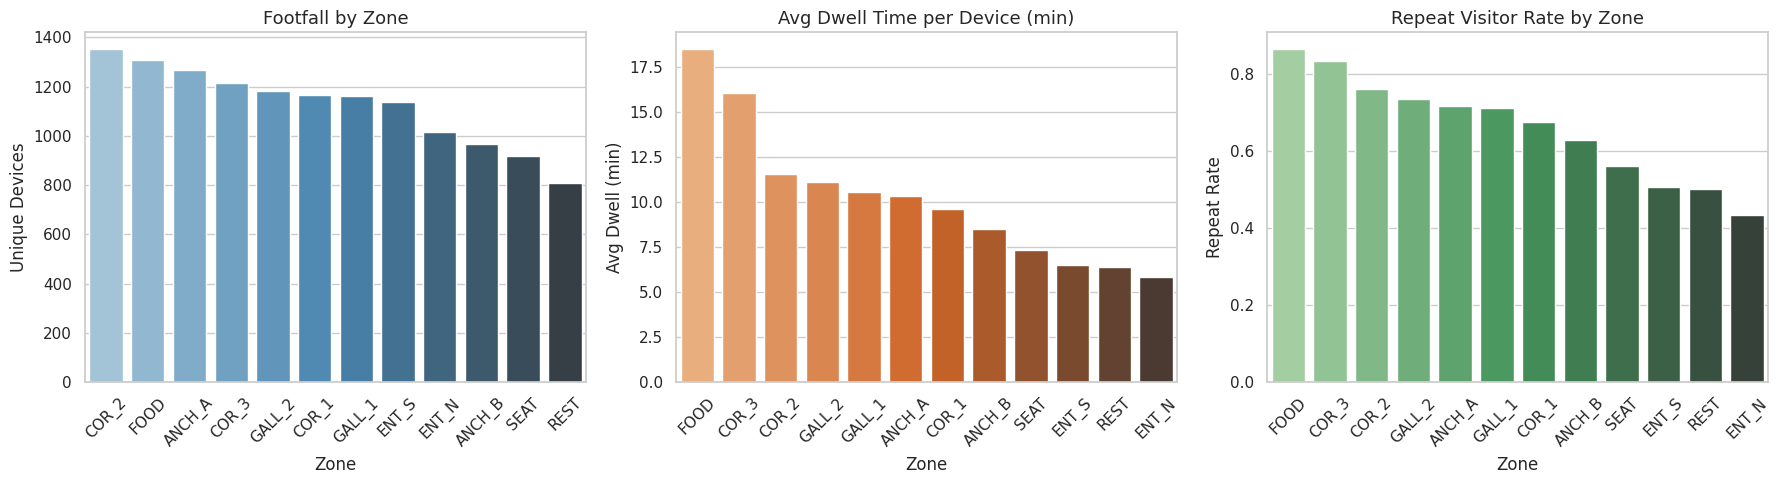

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Footfall
ff = zone_metrics.sort_values('unique_reach', ascending=False)
sns.barplot(data=ff, x='zone_id', y='unique_reach', palette='Blues_d', ax=axes[0])
axes[0].set_title('Footfall by Zone', fontsize=13)
axes[0].set_xlabel('Zone'); axes[0].set_ylabel('Unique Devices')
axes[0].tick_params(axis='x', rotation=45)

# Dwell
dw = zone_metrics.sort_values('avg_dwell_per_device_min', ascending=False)
sns.barplot(data=dw, x='zone_id', y='avg_dwell_per_device_min', palette='Oranges_d', ax=axes[1])
axes[1].set_title('Avg Dwell Time per Device (min)', fontsize=13)
axes[1].set_xlabel('Zone'); axes[1].set_ylabel('Avg Dwell (min)')
axes[1].tick_params(axis='x', rotation=45)

# Repeat rate
rr = zone_metrics.sort_values('repeat_rate', ascending=False)
sns.barplot(data=rr, x='zone_id', y='repeat_rate', palette='Greens_d', ax=axes[2])
axes[2].set_title('Repeat Visitor Rate by Zone', fontsize=13)
axes[2].set_xlabel('Zone'); axes[2].set_ylabel('Repeat Rate')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 7b. Hourly Traffic Heatmap

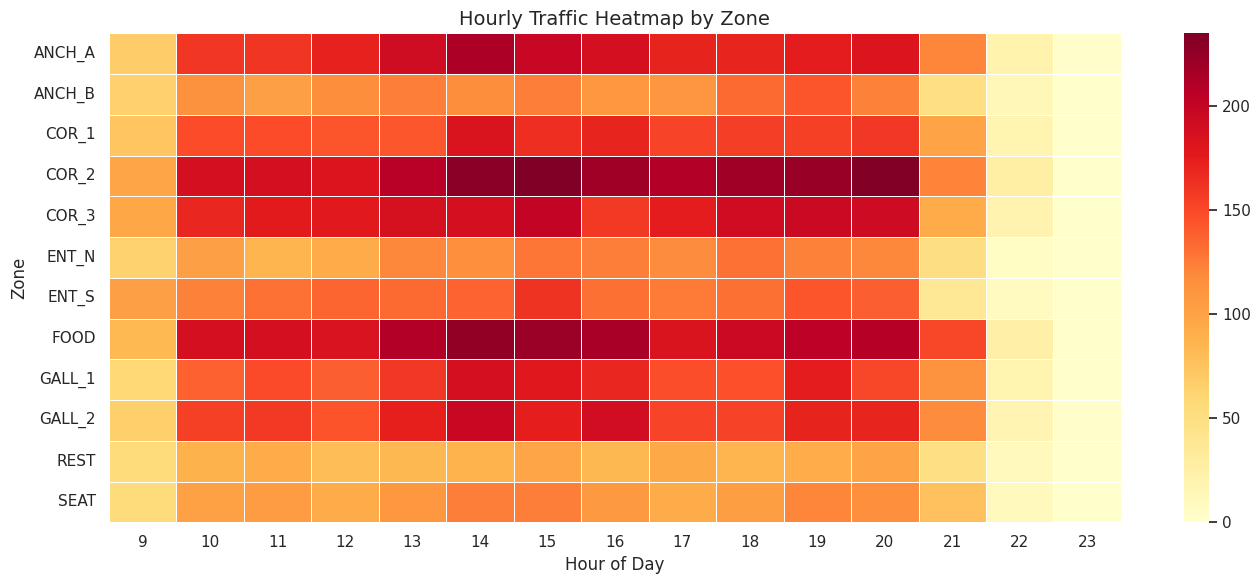

In [8]:
sessionized['hour'] = sessionized['timestamp'].dt.hour
hourly = sessionized.groupby(['zone_id','hour'])['device_id'].nunique().reset_index(name='devices')
pivot = hourly.pivot(index='zone_id', columns='hour', values='devices').fillna(0)

plt.figure(figsize=(14, 6))
sns.heatmap(pivot, cmap='YlOrRd', linewidths=0.4, annot=False)
plt.title('Hourly Traffic Heatmap by Zone', fontsize=14)
plt.xlabel('Hour of Day'); plt.ylabel('Zone')
plt.tight_layout()
plt.show()

### 7c. Zone Transition Flow Matrix

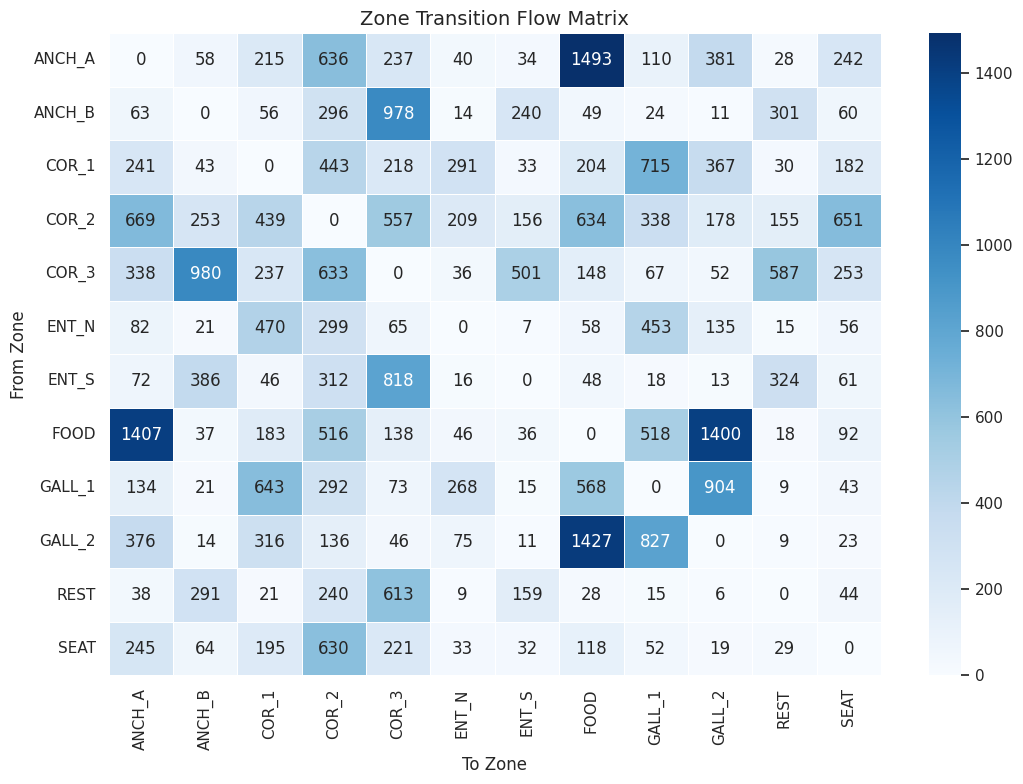

In [9]:
flow_pivot = T.pivot(index='from_zone', columns='to_zone', values='n').fillna(0)

plt.figure(figsize=(11, 8))
sns.heatmap(flow_pivot, cmap='Blues', annot=True, fmt='.0f', linewidths=0.4)
plt.title('Zone Transition Flow Matrix', fontsize=14)
plt.xlabel('To Zone'); plt.ylabel('From Zone')
plt.tight_layout()
plt.show()

### 7d. Premium Space Score (PSS) Bar Chart

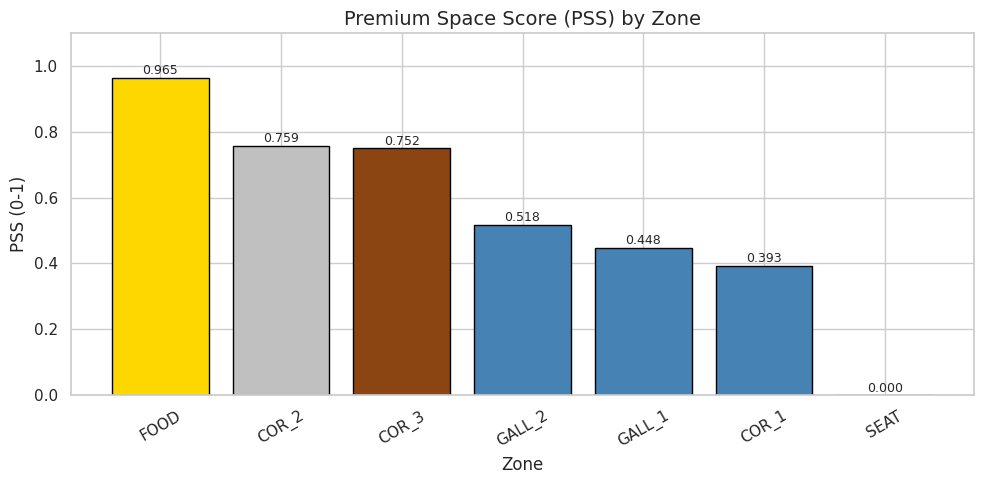

In [10]:
colors = ['gold' if i == 0 else ('silver' if i == 1 else ('saddlebrown' if i == 2 else 'steelblue'))
          for i in range(len(ranked))]

plt.figure(figsize=(10, 5))
bars = plt.bar(ranked['zone_id'], ranked['premium_score'], color=colors, edgecolor='black')
for bar, val in zip(bars, ranked['premium_score']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.3f}', ha='center', fontsize=9)
plt.title('Premium Space Score (PSS) by Zone', fontsize=14)
plt.xlabel('Zone'); plt.ylabel('PSS (0-1)')
plt.ylim(0, 1.1)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## 8. Venue Zone Map — Spatial Visualization

Zones are plotted at their physical (x, y) coordinates. **Orange rings** highlight the top premium placement candidates identified by the PSS model. This is the spatial plot shown in the article.

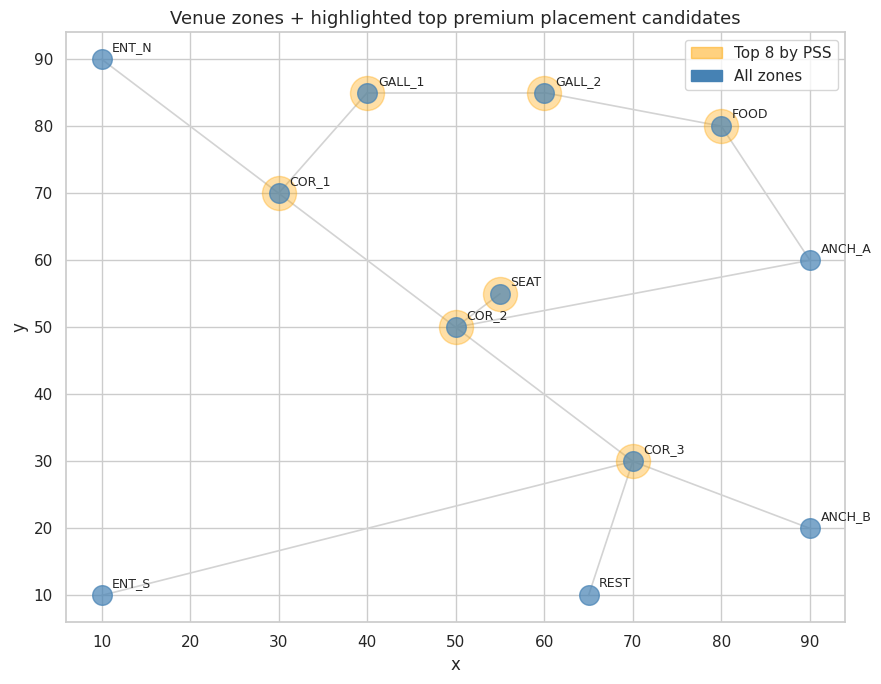

In [11]:
def plot_zone_scores(zones, ranked, top_n=8):
    df = zones.merge(ranked[['zone_id','premium_score']], on='zone_id', how='left').fillna(0)
    top = ranked.head(top_n).merge(zones, on='zone_id', how='left')

    fig, ax = plt.subplots(figsize=(9, 7))

    # Draw edges
    edge_lookup = zones.set_index('zone_id')[['x','y']].to_dict('index')
    edges_list = [
        ('ENT_N','COR_1'), ('ENT_S','COR_3'),
        ('COR_1','COR_2'), ('COR_2','COR_3'),
        ('COR_2','SEAT'),
        ('COR_1','GALL_1'), ('GALL_1','GALL_2'), ('GALL_2','FOOD'),
        ('COR_2','ANCH_A'), ('COR_3','ANCH_B'),
        ('COR_3','REST'), ('FOOD','ANCH_A'),
    ]
    for a, b in edges_list:
        xa, ya = edge_lookup[a]['x'], edge_lookup[a]['y']
        xb, yb = edge_lookup[b]['x'], edge_lookup[b]['y']
        ax.plot([xa, xb], [ya, yb], color='lightgray', linewidth=1.2, zorder=1)

    # Highlight top-N with orange halo
    ax.scatter(top['x'], top['y'], s=600, alpha=0.35, color='orange', zorder=2, label='Top candidates')

    # All zones
    ax.scatter(df['x'], df['y'], s=200, alpha=0.7, color='steelblue', zorder=3)

    # Labels
    for _, r in df.iterrows():
        ax.text(r['x'] + 1.2, r['y'] + 1.2, r['zone_id'], fontsize=9, zorder=4)

    ax.set_title('Venue zones + highlighted top premium placement candidates', fontsize=13)
    ax.set_xlabel('x'); ax.set_ylabel('y')
    top_patch = mpatches.Patch(color='orange', alpha=0.5, label=f'Top {top_n} by PSS')
    zone_patch = mpatches.Patch(color='steelblue', label='All zones')
    ax.legend(handles=[top_patch, zone_patch])
    plt.tight_layout()
    plt.show()

plot_zone_scores(zones, ranked, top_n=8)

## 9. Final Recommendations

In [12]:
print('=== TOP PREMIUM AD PLACEMENT ZONES ===')
print()
for i, row in ranked.iterrows():
    tier = ['1st', '2nd', '3rd'][i] if i < 3 else f'{i+1}th'
    print(f'{tier} | {row["zone_id"]:8s} ({row["name"]:<22}) | PSS: {row["premium_score"]:.3f}')
    print(f'       {row["justification"]}')
    print()
print('KEY INSIGHT: Corridor zones (COR_1, COR_2) score high via throughflow even with low dwell.')
print('Food Court and Seating win on dwell + repeat — ideal for detailed product displays.')
print('Entrance scores low despite top footfall — use single-phrase or logo-only ads there.')

=== TOP PREMIUM AD PLACEMENT ZONES ===

1st | FOOD     (Food Court            ) | PSS: 0.965
       Reach=1310 devices | Avg dwell=18.51 min/device | Flow=9166 transitions | Repeat=86.48%

2nd | COR_2    (Main Corridor 2       ) | PSS: 0.759
       Reach=1353 devices | Avg dwell=11.58 min/device | Flow=8672 transitions | Repeat=76.04%

3rd | COR_3    (Main Corridor 3       ) | PSS: 0.752
       Reach=1213 devices | Avg dwell=16.06 min/device | Flow=7796 transitions | Repeat=83.24%

4th | GALL_2   (Gallery 2             ) | PSS: 0.518
       Reach=1184 devices | Avg dwell=11.12 min/device | Flow=6726 transitions | Repeat=73.51%

5th | GALL_1   (Gallery 1             ) | PSS: 0.448
       Reach=1160 devices | Avg dwell=10.54 min/device | Flow=6107 transitions | Repeat=71.12%

6th | COR_1    (Main Corridor 1       ) | PSS: 0.393
       Reach=1164 devices | Avg dwell=9.63 min/device | Flow=5588 transitions | Repeat=67.62%

7th | SEAT     (Seating / Atrium      ) | PSS: 0.000
       Reach=9

## 10. Key Takeaways

- **Graph structure matters:** COR_2 scores 0.89 not because people linger, but because 8,000+ daily transitions pass through it.
- **Dwell cap prevents data artifacts:** Without the 8-min cap, sparse pings in high-stickiness zones like Food Court would create artificially inflated dwell times.
- **Weights are adjustable:** For timed campaigns (movie posters), increase throughflow weight. For product demos, increase dwell weight.
- **Sequential campaigns follow natural flows:** The ENT_N → COR_1 → GALL_1 → FOOD path supports a 4-part progressive narrative campaign.
- **Privacy first:** All device IDs are hashed/anonymous. Raw pings should be deleted after session aggregation in production deployments.